In [2]:
import pandas as pd
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import sys
sys.path.append('../module')
from utils import log_diff, log_diff_inv, load_fx_data

%matplotlib inline

# 時系列データ読み込み

In [3]:
instrument_list = ['USD_JPY', 'GBP_JPY', 'EUR_JPY']

df_dict = load_fx_data(instrument_list)
# df_dict['USD_JPY']

df_dict_stable = {}
for instrument in df_dict.keys():
    df_stable = df_dict[instrument].copy()
    for column in df_stable.columns:
        df_stable[column] = log_diff(df_stable[column].values)
    df_dict_stable[instrument] = df_stable
df_dict_stable['EUR_JPY']

,Open_ask,High_ask,Low_ask,Close_ask,Volume,Open_bid,High_bid,Low_bid,Close_bid
Time,,,,,,,,,
2014-01-01 22:00:00+00:00,4.976223,4.977857,4.961858,4.965401,11.870698,4.975188,4.977478,4.961711,4.964438
2014-01-02 22:00:00+00:00,-0.010676,-0.012310,-0.006207,-0.005869,-0.227903,-0.010687,-0.012496,-0.006229,-0.005714
2014-01-05 22:00:00+00:00,-0.006100,-0.004151,-0.003266,-0.003141,0.094074,-0.005411,-0.003712,-0.003246,-0.002848
2014-01-06 22:00:00+00:00,-0.003057,-0.001353,0.003097,0.002594,-0.081550,-0.003220,-0.001339,0.003098,0.002602
2014-01-07 22:00:00+00:00,0.002594,0.004087,0.001260,-0.000309,0.108926,0.002630,0.004039,0.001260,-0.000429
...,...,...,...,...,...,...,...,...,...
2018-12-03 22:00:00+00:00,-0.000341,-0.000728,-0.007206,-0.008522,0.346793,-0.000341,-0.000961,-0.007222,-0.008409
2018-12-04 22:00:00+00:00,-0.008155,-0.004372,0.001323,0.003807,-0.512500,-0.007693,-0.004163,0.001323,0.003808
2018-12-05 22:00:00+00:00,0.003463,-0.000265,-0.000924,-0.001753,0.845674,0.003464,-0.000506,-0.000932,-0.001754


In [4]:
def least_square(A,b):
    return np.linalg.inv(A.T@A)@A.T@b

# 遅れ座標系

In [5]:
def compute_delaied_arr(arr, K=3):
    N = len(arr) - K + 1
    if N < 0:
        print('len of arr must be greater than K')
        return None
    delaied_arr = []
    for n in range(N):
        delaied_arr.append(arr[n:n+K])
    return np.array(delaied_arr)

def delaied_feature_label(arr, K=3):
    if len(arr) < K:
        print('len of arr must be greater than K')
        return None
    feature_arr = compute_delaied_arr(arr[:-1], K) # label用に最後のデータは残す．
    label_arr = arr[K:]
    return feature_arr, label_arr

arr = np.array([1,-1.00001,1,-1, 1, -1, 1, -1, 1, -1])
X, Y = delaied_feature_label(arr, K=1)
for i in range(len(X)):
    print(f'x: {X[i]}, y: {Y[i]}')

def delaied_linear_rg(arr, K):
    if len(arr) < K+1:
        print('len of arr must be greater than K+1') # 線形回帰するため
        return None
    X, Y = delaied_feature_label(arr, K)
    coefs = least_square(X, Y)
    return coefs

x: [1.], y: -1.00001
x: [-1.00001], y: 1.0
x: [1.], y: -1.0
x: [-1.], y: 1.0
x: [1.], y: -1.0
x: [-1.], y: 1.0
x: [1.], y: -1.0
x: [-1.], y: 1.0
x: [1.], y: -1.0


In [6]:
arr = np.array([1,-1.00001,1,-1, 1, -1, 1, -1, 1, -1])

coefs = delaied_linear_rg(arr, K=3)
print(' + '.join([f'{coef}x[n-{i+1}]' for i, coef in enumerate(coefs[::-1])]))

-0.9999885559082031x[n-1] + 1.52587890625e-05x[n-2] + 0.0x[n-3]


In [22]:
class DelaiedLinearRegression:
    def __init__(self, time_series, K):
        if len(time_series) < K + 1:
            print('len of time_series must be greater than K+1')
            return
        
        self.time_series = time_series
        self.K = K

        self.features = self._compute_delaied_arr(time_series[:-1])
        self.labels = time_series[K:]

    def fit(self):
        X, Y = self.features, self.labels
        coefs = least_square(X, Y) # 過去の係数から順に入っている．
        self.coefs = coefs
        self.c = self.time_series.mean()

    def coefs(self):
        return self.coefs
    
    def c(self):
        return self.c

    def predict(self, test_time_series):
        if len(test_time_series) < self.K:
            print('len of test_time_series must be greater than K')
            return
        test_features = self._compute_delaied_arr(test_time_series)
        predict_series = [self.coefs@vals + self.c for vals in test_features]
        return np.array(predict_series)
    
    def _compute_delaied_arr(self, arr):
        N = len(arr) - self.K + 1
        delaied_arr = [arr[n:n+self.K] for n in range(N)]
        return np.array(delaied_arr)

# 単純な時系列に対して実行

-0.9999885559082031x[n-1] + 1.52587890625e-05x[n-2] + 0.0x[n-3]-1.0000000000065511e-06


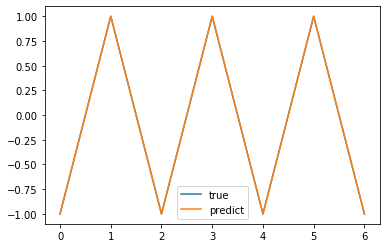

In [10]:
dlr = DelaiedLinearRegression(arr, K=3)
dlr.fit()
dlr.coefs
predict = dlr.predict(arr[:-1])

plt.plot(arr[3:], label='true')
plt.plot(predict, label='predict')
plt.legend()

# 回帰係数を確認
print(' + '.join([f'{coef}x[n-{i+1}]' for i, coef in enumerate(coefs[::-1])]) + f'{dlr.c}')

3.520147021339796x[n-1] + -5.077683537174066x[n-2] + 3.5201470213389072x[n-3] + -0.9999999999994229x[n-4]-5.551115123125783e-18


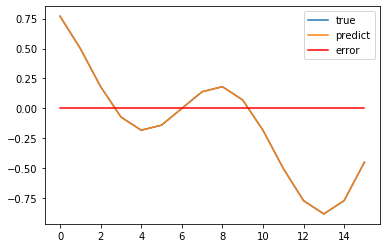

In [11]:
Tstep = 20
sin = 0.5*np.sin(np.pi*np.arange(Tstep)/10) + 0.5*np.sin(np.pi*np.arange(Tstep)/5)
K = 4
dlr = DelaiedLinearRegression(sin, K=K)
dlr.fit()
dlr.coefs
predict = dlr.predict(sin[:-1])

plt.plot(sin[K:], label='true')
plt.plot(predict, label='predict')
plt.plot(sin[K:]- predict, label='error', color='r')
plt.legend()

# 回帰係数を確認
print(' + '.join([f'{coef}x[n-{i+1}]' for i, coef in enumerate(dlr.coefs[::-1])]) + f'{dlr.c}')

## 観察
- $ K $の値を適切にしないとうまくいかない．特に大きければ良いわけではない．

# fxデータに対して実行

-0.11562843116018x[n-1] + 0.2616223805964152x[n-2] + 0.01010409441046057x[n-3] + -0.4221386287786086x[n-4] + -0.3363119044148846x[n-5] + -0.00818283556519006x[n-6] + 0.0364628560634119x[n-7] + -0.04761256459649155x[n-8] + -0.00894386357923379x[n-9] + -0.10123333348004715x[n-10] + -0.02243778502884226x[n-11] + -0.07154625749701218x[n-12] + -0.08760918837261647x[n-13] + -0.11698117499974381x[n-14] + 0.23079007624960518x[n-15] + 0.07416070864303989x[n-16] + -0.05204286130715013x[n-17] + -0.03892752709071423x[n-18] + 0.12610480610455752x[n-19] + 0.29293721953855356x[n-20] + -0.0002982897237023252


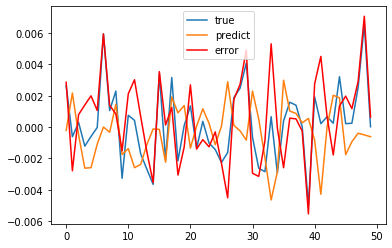

In [37]:
instrument = 'USD_JPY'
price = 'Close_ask' # 買値の終値
K = 20

fx_time_series = df_dict_stable[instrument][price].values[1:]
fx_dlr = DelaiedLinearRegression(fx_time_series[:100], K=K)
fx_dlr.fit()
fx_dlr.coefs

test_label = fx_time_series[100:150]
test_feature = fx_time_series[100-K:150-1]
predict = fx_dlr.predict(test_feature)

plt.plot(test_label, label='true')
plt.plot(predict, label='predict')
plt.plot(test_label- predict, label='error', color='r')


plt.legend()

# 回帰係数を確認
print(' + '.join([f'{coef}x[n-{i+1}]' for i, coef in enumerate(fx_dlr.coefs[::-1])]) + f' + {fx_dlr.c}')

In [139]:
np.abs(test_label-predict).mean()

0.00026781833832079105

あまりうまくいかなそう